# Torchgeo Первый эксперимент

## Введение

Цель этого ноутбука - попробовать применить torchgeo к нашему созданному датасету:
* Создание наборов растровых данных, загрузчиков данных и сэмплеров для изображений и масок;
* Набор данных о пересечениях;
* Нормализация данных;
* Создание спектрального индекса;
* Создание модели сегментации (DeepLabV3);
* Функция потерь и показатели; и
* Цикл обучения.



In [1]:
# для колаба
# !pip install rasterio -q
# !pip install torchgeo -q

In [2]:
# Проверка cuda и ее доступности
import torch
print(f'Cuda is available: {torch.cuda.is_available()}')
print(f'PyTorch version: {torch.__version__}')
print('*'*10)
print(f'_CUDA version: ')
!nvcc --version
print('*'*10)
print(f'CUDNN version: {torch.backends.cudnn.version()}')
print(f'Available GPU devices: {torch.cuda.device_count()}')
print(f'Device Name: {torch.cuda.get_device_name()}')

c:\Users\Кирилл\Documents\GitHub\CV_ITMO_2023\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Cuda is available: True
PyTorch version: 1.13.1+cu117
**********
_CUDA version: 
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Jun__8_16:59:34_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.7, V11.7.99
Build cuda_11.7.r11.7/compiler.31442593_0
**********
CUDNN version: 8500
Available GPU devices: 1
Device Name: NVIDIA GeForce GTX 1650 with Max-Q Design


## Dataset

Датасет мы создали ранее, его можно найти в папке `data/output/for_torchgeo_way/`




## Imports

In [3]:
from pathlib import Path
from typing import Optional, Iterable, List, Callable
import matplotlib.pyplot as plt

import rasterio as rio

from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples
from torchgeo.samplers import RandomGeoSampler, Units
from torchgeo.transforms import indices
from torch.utils.data import DataLoader

import torch


In [4]:
import logging
# this line is to avoid warnings from Rasterio to be printed on screen
# the warning is explained here: https://stackoverflow.com/questions/74089170/suppress-rasterio-warning-warning-1-tiffreaddirectory
logger = logging.getLogger("rasterio")
logger.setLevel(logging.ERROR)

In [5]:
root = Path('./data/output/for_torchgeo_way')
assert root.exists()

## Создание датасета

Нужно подготовить его к загрузке в нейронную сеть. Для этого мы создадим экземпляр класса Raster Dataset, предоставляемого TorchGeo, и укажем на определенный каталог. Функция `scale` применит масштабирование - `1e-4`, (увидел у одного ученого проверим, нужно ли это делать). Как только наборы данных созданы, мы можем комбинировать изображения с масками (метками), используя оператор `&`.

In [6]:
def scale(item: dict):
    item['image'] = item['image'] / 10000
    return item

In [7]:
#res - resolution, типа масштаб снимка, 10 значит 10м в пикселе, как есть в сентинеле
train_imgs = RasterDataset(root=(root/'img_f/train').as_posix(), crs='epsg:32637', res=10, transforms=scale) 
train_msks = RasterDataset(root=(root/'mask_f/train').as_posix(), crs='epsg:32637', res=10)

valid_imgs = RasterDataset(root=(root/'img_f/val').as_posix(), crs='epsg:32637', res=10, transforms=scale)
valid_msks = RasterDataset(root=(root/'mask_f/val').as_posix(), crs='epsg:32637', res=10)

# IMPORTANT
train_msks.is_image = False
valid_msks.is_image = False

train_dset = train_imgs & train_msks
valid_dset = valid_imgs & valid_msks

train_sampler = RandomGeoSampler(train_imgs, size=256, length=128, units=Units.PIXELS)
valid_sampler = RandomGeoSampler(valid_imgs, size=256, length=64, units=Units.PIXELS)


CRS (Coordinate Reference System) - TorchGeo требует, чтобы все изображения были с одинаковой системой координат.

### Понимание sampler -а

Чтобы создать патчи для обучения, которые могут быть загружены в нейронную сеть из нашего набора данных, нам нужно выбрать выборки фиксированных размеров. Torch Geo имеет много сэмплеров, но мы попробуем класс `RandomGeoSampler`. По сути, сэмплер выбирает случайные ограничивающие рамки фиксированного размера, которые принадлежат исходному изображению. Затем эти ограничивающие рамки используются в `RasterDataset` для запроса нужной нам части изображения. Пример с использованием ранее созданных сэмплеров ниже.

In [8]:
bbox = next(iter(train_sampler))
bbox

BoundingBox(minx=306202.95137286186, maxx=308762.95137286186, miny=6347919.420487881, maxy=6350479.420487881, mint=0.0, maxt=9.223372036854776e+18)

In [9]:
sample = train_dset[bbox]
sample.keys()

dict_keys(['crs', 'bbox', 'image', 'mask'])

In [10]:
sample['image'].shape, sample['mask'].shape

(torch.Size([4, 256, 256]), torch.Size([1, 256, 256]))

Обратите внимание, что теперь у нас есть участки одинакового размера (..., 512 x 512)

## Создание Dataloaders

Создание `DataLoader` в TorchGeo очень простое, такое же, как и в Pytorch (фактически используется тот же класс). Обратите внимание ниже, что мы используем те же sampler, которые ранее задали. Дополнительно мы сообщаем dataset, который загрузчик данных будет использовать для извлечения данных, batch_size (количество выборок в каждом пакете) и функцию сортировки, которая определяет, как “объединить” несколько выборок в один пакет.

Наконец, мы можем выполнить итерацию через загрузчик данных, чтобы извлекать из него пакеты. Чтобы протестировать это, давайте получим первую партию.

In [11]:
train_dataloader = DataLoader(train_dset, sampler=train_sampler, batch_size=4, collate_fn=stack_samples)
valid_dataloader = DataLoader(valid_dset, sampler=valid_sampler, batch_size=4, collate_fn=stack_samples)

train_batch = next(iter(train_dataloader))
valid_batch = next(iter(valid_dataloader))
train_batch.keys(), valid_batch.keys()

(dict_keys(['crs', 'bbox', 'image', 'mask']),
 dict_keys(['crs', 'bbox', 'image', 'mask']))

## Batch визуализация

Теперь, когда мы можем извлекать пакеты из наших наборов данных, давайте создадим функцию для отображения пакетов.

Функция `plot_batch` автоматически проверит количество элементов в пакете и наличие связанных масок, чтобы соответствующим образом упорядочить выходную сетку.

In [12]:
# from typing import Iterable, List, Optional, Callable
# import torch

# def plot_imgs(images: Iterable, axs: Iterable, chnls: List[int] = [0, 1, 2], bright: float = 5.):
#     for img, ax in zip(images, axs):
#         arr = torch.clamp(bright * img, min=0, max=1).numpy()
#         rgb = arr.transpose(1, 2, 0)[:, :, chnls]
#         ax.imshow(rgb)
#         ax.axis('off')


# def plot_msks(masks: Iterable, axs: Iterable):
#     for mask, ax in zip(masks, axs):
#         ax.imshow(mask.squeeze().numpy(), cmap='Greens')
#         ax.axis('off')

# def plot_batch(batch: dict, bright: float = 5., cols: int = 4, width: int = 5, chnls: List[int] = [0, 1, 2]):

#     # Get the samples and the number of items in the batch
#     samples = unbind_samples(batch.copy())
    
#     # if batch contains images and masks, the number of images will be doubled
#     n = 2 * len(samples) if ('image' in batch) and ('mask' in batch) else len(samples)

#     # calculate the number of rows in the grid
#     rows = n//cols + (1 if n%cols != 0 else 0)

#     # create a grid
#     _, axs = plt.subplots(rows, cols, figsize=(cols*width, rows*width))  

#     if ('image' in batch) and ('mask' in batch):
#         # plot the images on the even axis
#         plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1)[::2], chnls=chnls, bright=bright) 

#         # plot the masks on the odd axis
#         plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)[1::2]) 

#     else:

#         if 'image' in batch:
#             plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1), chnls=chnls, bright=bright) 
    
#         elif 'mask' in batch:
#             plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)) 

In [13]:
# plot_batch(train_batch)

## Стандартизация данных и спектральный индекс

Обычно методы машинного обучения (включая глубокое обучение) выигрывают от масштабирования функций. Это означает стандартное отклонение около 1 и нулевое среднее значение, применяя следующую формулу:
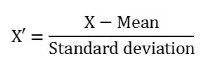

Чтобы сделать это, нам нужно сначала найти среднее значение и стандартное отклонение для каждого из 4х каналов в наборе данных.

Давайте определим функцию, вычисляющую эти статистические данные, и запишем ее результаты в переменные mean и std. Мы будем использовать наш ранее установленный пакет rasterio, чтобы открыть изображения и выполнить простое усреднение статистики для каждого пакета / канала. Для стандартного отклонения этот метод является приближенным. Для более точного расчета, пожалуйста, обратитесь к: http://notmatthancock.github.io/2017/03/23/simple-batch-stat-updates.htm.

In [14]:
def calc_statistics(dset: RasterDataset):
        """
        Calculate the statistics (mean and std) for the entire dataset
        Warning: This is an approximation. The correct value should take into account the
        mean for the whole dataset for computing individual stds.
        For correctness I suggest checking: http://notmatthancock.github.io/2017/03/23/simple-batch-stat-updates.html
        """

        # To avoid loading the entire dataset in memory, we will loop through each img
        # The filenames will be retrieved from the dataset's rtree index
        files = [item.object for item in dset.index.intersection(dset.index.bounds, objects=True)]

        # Reseting statistics
        accum_mean = 0
        accum_std = 0

        for file in files:
            img = rio.open(file).read()/10000 #type: ignore
            accum_mean += img.reshape((img.shape[0], -1)).mean(axis=1)
            accum_std += img.reshape((img.shape[0], -1)).std(axis=1)

        # at the end, we shall have 2 vectors with lenght n=chnls
        # we will average them considering the number of images
        return accum_mean / len(files), accum_std / len(files)

In [15]:
class MyNormalize(torch.nn.Module):
    def __init__(self, mean: List[float], stdev: List[float]):
        super().__init__()

        self.mean = torch.Tensor(mean)[:, None, None]
        self.std = torch.Tensor(stdev)[:, None, None]

    def forward(self, inputs: dict):

        x = inputs[..., : len(self.mean), :, :]

        # if batch
        if inputs.ndim == 4:
            x = (x - self.mean[None, ...]) / self.std[None, ...]

        else:
            x = (x - self.mean) / self.std

        inputs[..., : len(self.mean), :, :] = x

        return inputs

    def revert(self, inputs: dict):
        """
        De-normalize the batch.

        Args:
            inputs (dict): Dictionary with the 'image' key
        """

        x = inputs[..., : len(self.mean), :, :]

        # if batch
        if x.ndim == 4:
            x = inputs[:, : len(self.mean), ...]
            x = x * self.std[None, ...] + self.mean[None, ...]
        else:
            x = x * self.std + self.mean

        inputs[..., : len(self.mean), :, :] = x

        return inputs


In [16]:
normalize = MyNormalize(*calc_statistics(train_imgs))

tfms = torch.nn.Sequential(
    indices.AppendNDVI(index_nir=3, index_red=0),
    normalize
)

In [17]:
transformed_batch = tfms(train_batch['image'])
print(transformed_batch.shape)

torch.Size([4, 5, 256, 256])


Note that our transformed batch has now 5 channels, instead of 4.

> Important: the normalize method we created will apply the normalization just to the original bands and it will ignore the previously appended indices. That’s important to avoid errors due to distinct shapes between the batch and the mean and std vectors.

## Segmentation Model

For the semantic segmentation model, we are going to use a predefined architecture that is available in Pytorch. Looking at list (https://pytorch.org/vision/stable/models.html#semantic-segmentation) it is possible to note 3 models available for semantic segmentation, but one (LRASPP) is intended for mobile applications. In our tutorial, we will use the DeepLabV3 model.

Here, we will create a DeepLabV3 model for 2 classes. In this case, I will skip the pretrained weights, as the weights represent another domain (not water segmentation from multispectral imagery).

In [18]:
from torchvision.models.segmentation import deeplabv3_resnet50
model = deeplabv3_resnet50(weights=None, num_classes=2)

model

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

The first thing we have to pay attention in the model architecture is the number of channels expected in the first convolution (Conv2d), that is defined as 3. That’s because the model is prepared to work with RGB images. After the first convolution, the 3 channels will produce 64 channels in lower resolution, and so on. As we have now 9 channels, we will change this first processing layer to adapt correctly to our model. We can do this by replacing the first convolutional layer for a new one, by following the commands. Finally, we check a mock batch can pass through the model and provide the output with 2 channels (water / no_water) as desired.

In [19]:
backbone = model.get_submodule('backbone')

conv = torch.nn.modules.conv.Conv2d(
    in_channels=5, 
    out_channels=64, 
    kernel_size=(7, 7),
    stride=(2, 2),
    padding=(3, 3),
    bias=False
)
backbone.register_module('conv1', conv)

pred = model(torch.randn(3, 5, 256, 256))
pred['out'].shape

torch.Size([3, 2, 256, 256])

## Training Loop

The training function should receive the number of epochs, the model, the dataloaders, the loss function (to be optimized) the accuracy function (to assess the results), the optimizer (that will adjust the parameters of the model in the correct direction) and the transformations to be applied to each batch.

In [20]:
def train_loop(
    epochs: int, 
    train_dl: DataLoader, 
    val_dl: Optional[DataLoader], 
    model: torch.nn.Module, 
    loss_fn: Callable, 
    optimizer: torch.optim.Optimizer, 
    acc_fns: Optional[List]=None, 
    batch_tfms: Optional[Callable]=None
):
    # size = len(dataloader.dataset)
    cuda_model = model.cuda()

    for epoch in range(epochs):
        accum_loss = 0
        for batch in train_dl:

            if batch_tfms is not None:
                batch['image'] = batch_tfms(batch['image'])

            X = batch['image'].cuda()
            y = batch['mask'].type(torch.long).cuda()
            pred = cuda_model(X)['out']
            loss = loss_fn(pred, y)

            # BackProp
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update the accum loss
            accum_loss += float(loss) / len(train_dl)

        # Testing against the validation dataset
        if acc_fns is not None and val_dl is not None:
            # reset the accuracies metrics
            acc = [0.] * len(acc_fns)

            with torch.no_grad():
                for batch in val_dl:

                    if batch_tfms is not None:
                        batch['image'] = batch_tfms(batch['image'])                    

                    X = batch['image'].type(torch.float32).cuda()
                    y = batch['mask'].type(torch.long).cuda()

                    pred = cuda_model(X)['out']

                    for i, acc_fn in enumerate(acc_fns):
                        acc[i] = float(acc[i] + acc_fn(pred, y)/len(val_dl))

            # at the end of the epoch, print the errors, etc.
            print(f'Epoch {epoch}: Train Loss={accum_loss:.5f} - Accs={[round(a, 3) for a in acc]}')
        else:

            print(f'Epoch {epoch}: Train Loss={accum_loss:.5f}')

## Loss and Accuracy Functions

For the loss function, normally the Cross Entropy Loss should work, but it requires the mask to have shape (N, d1, d2). In this case, we will need to squeeze our second dimension manually.

In [21]:
from sklearn.metrics import jaccard_score

def oa(pred, y):
    flat_y = y.squeeze()
    flat_pred = pred.argmax(dim=1)
    acc = torch.count_nonzero(flat_y == flat_pred) / torch.numel(flat_y)
    return acc

def iou(pred, y):
    flat_y = y.cpu().numpy().squeeze()
    flat_pred = pred.argmax(dim=1).detach().cpu().numpy()
    return jaccard_score(flat_y.reshape(-1), flat_pred.reshape(-1), zero_division=1.)    

def loss(p, t):    
    return torch.nn.functional.cross_entropy(p, t.squeeze())

## Training

> To train the model it is important to have CUDA GPUs available. In Colab, it can be done by changing the runtime type and re-running the notebook. 

In [22]:
# import gc
# gc.collect()
# torch.cuda.empty_cache()

In [23]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)
train_loop(15, train_dataloader, valid_dataloader, model, loss, optimizer, 
           acc_fns=[oa, iou], batch_tfms=tfms)

Epoch 0: Train Loss=nan - Accs=[0.997, 0.188]
Epoch 1: Train Loss=nan - Accs=[0.996, 0.188]
Epoch 2: Train Loss=nan - Accs=[0.995, 0.188]
Epoch 3: Train Loss=nan - Accs=[0.997, 0.188]
Epoch 4: Train Loss=nan - Accs=[0.998, 0.125]
Epoch 5: Train Loss=nan - Accs=[0.997, 0.312]
Epoch 6: Train Loss=nan - Accs=[0.998, 0.25]
Epoch 7: Train Loss=nan - Accs=[0.996, 0.188]
Epoch 8: Train Loss=nan - Accs=[0.998, 0.375]
Epoch 9: Train Loss=nan - Accs=[0.997, 0.438]
Epoch 10: Train Loss=nan - Accs=[0.997, 0.25]
Epoch 11: Train Loss=nan - Accs=[0.996, 0.312]
Epoch 12: Train Loss=nan - Accs=[0.996, 0.312]
Epoch 13: Train Loss=nan - Accs=[0.996, 0.188]
Epoch 14: Train Loss=nan - Accs=[0.996, 0.312]
